In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_df = pd.read_csv("train.csv")

print train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


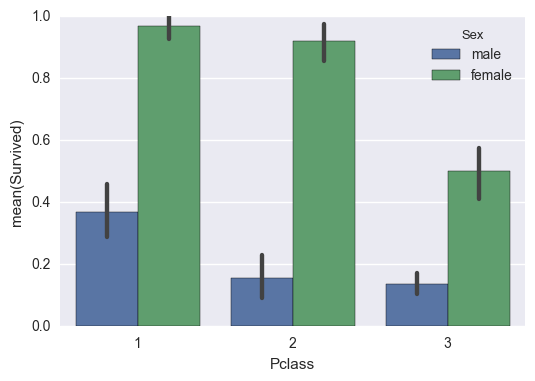

In [3]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train_df)

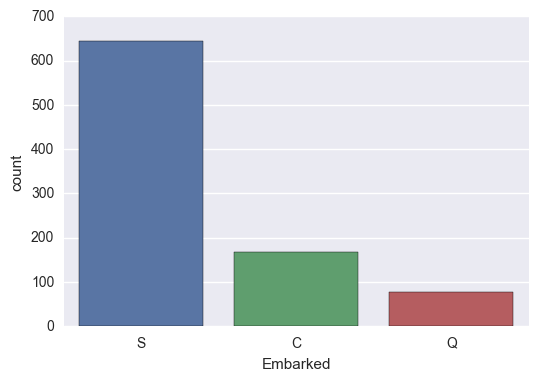

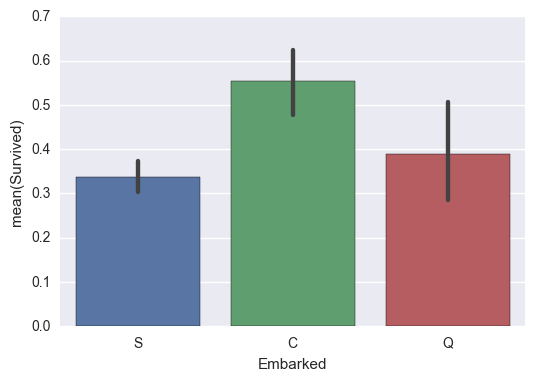

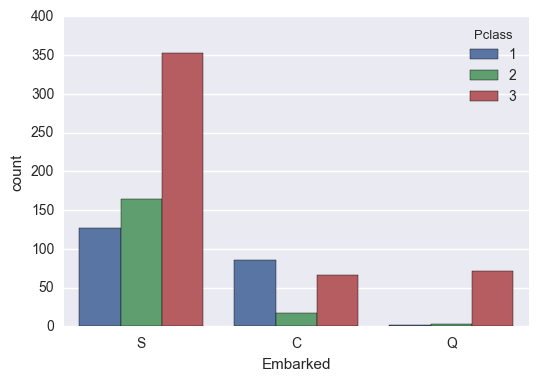

In [4]:
sns.countplot(x='Embarked', data=train_df)
plt.show()
sns.barplot(x='Embarked', y='Survived', data=train_df)
plt.show()
sns.countplot(x='Embarked', hue='Pclass', data=train_df)
plt.show()

People from C seem to have a significantly better rate of survival rate than people from ports S or Q. Perhaps it is because they have the most people from first class.

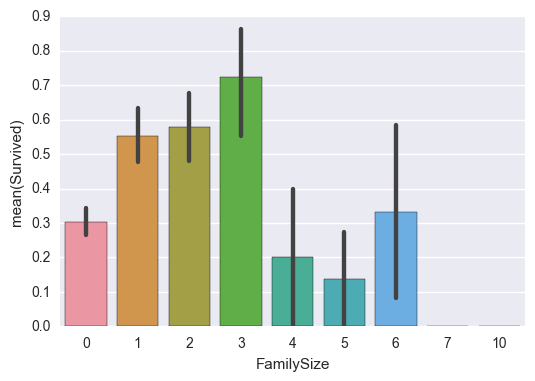

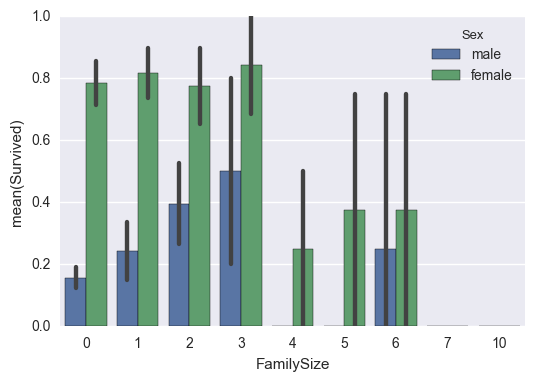

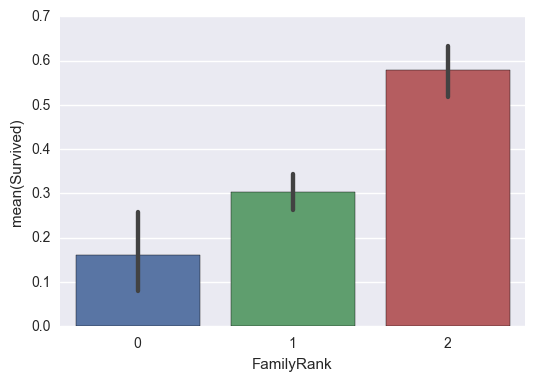

In [5]:
train_df["FamilySize"] = train_df["Parch"] + train_df["SibSp"]
sns.barplot(x="FamilySize", y="Survived", data=train_df)
plt.show()
sns.barplot(x="FamilySize", y="Survived", hue='Sex', data=train_df)
plt.show()

train_df["FamilyRank"] = train_df["FamilySize"].map(lambda x: 1 if x == 0 else 2 if x < 4 else 0)
sns.barplot(x="FamilyRank", y="Survived", data=train_df)

People in small families (size 1 to 3) seem to have significantly better survival chances than single people.

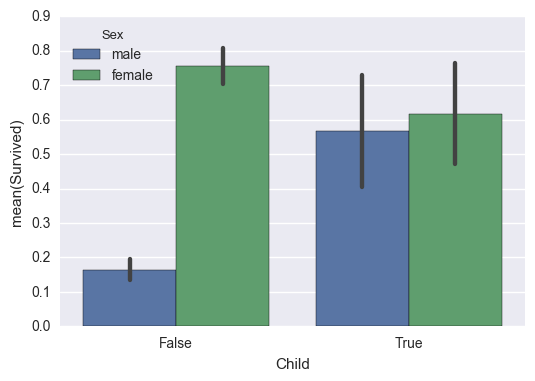

In [6]:
train_df["Child"] = train_df["Age"] <= 13
sns.barplot(x="Child", y="Survived", hue="Sex", data=train_df)

It seems that the difference in survival rates between diminishes sigificantly for children and young teens.

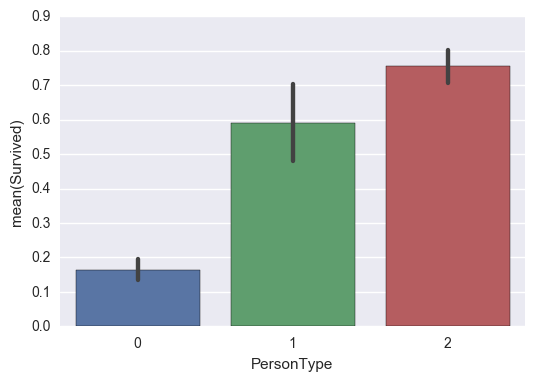

In [7]:
train_df["PersonType"] = train_df[["Sex", "Child"]].apply(lambda a: 1 if a["Child"] else 2 if a["Sex"] == "female" else 0, axis=1)
sns.barplot(x="PersonType", y="Survived", data=train_df)

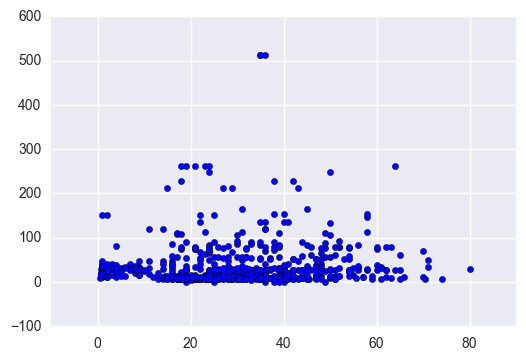

In [21]:
ages_fares = train_df[['Age', 'Fare']].dropna(axis=0)
ages = ages_fares['Age'].tolist()
fares = ages_fares['Fare'].tolist()
plt.scatter(ages, fares)
plt.show()

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
FamilySize     891 non-null int64
FamilyRank     891 non-null int64
Child          891 non-null bool
PersonType     891 non-null int64
dtypes: bool(1), float64(2), int64(8), object(5)
memory usage: 105.4+ KB


In [9]:
keep_cols = ['PassengerId', 'Survived', 'EmbarkedLevels', 'Pclass', 'FamilyRank', 'PersonType']

def preprocess(df):
    # Fill the empty spots with the mode
    # TODO: think of a better idea
    df['Embarked'] = df['Embarked'].fillna('S')
    df['EmbarkedLevels'] = df['Embarked'].map({'S': 0, 'Q': 1, 'C': 2})
    
    # Small families have the best chance of survival
    def family_rank(x):
        if x == 0:
            return 1
        elif x < 4:
            return 2
        else:
            return 0
    df["FamilySize"] = df["Parch"] + df["SibSp"]
    df['FamilyRank'] = df['FamilySize'].map(family_rank)
    
    # In terms of survival chance, women > children > men
    def person_type(row):
        if row['Age'] < 13:
            return 1
        elif row['Sex'] == "female":
            return 2
        else:
            return 0
    
    df['PersonType'] = df.apply(person_type, axis=1)
    
    return df[keep_cols]

train_df = pd.read_csv("train.csv")
temp = preprocess(train_df)
print temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
PassengerId       891 non-null int64
Survived          891 non-null int64
EmbarkedLevels    891 non-null int64
Pclass            891 non-null int64
FamilyRank        891 non-null int64
PersonType        891 non-null int64
dtypes: int64(6)
memory usage: 41.8 KB
None


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [12]:
temp = temp.drop("PassengerId", axis=1)
X = temp.drop("Survived", axis=1).values
y = temp["Survived"].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=7)

clf = LogisticRegression(max_iter=10**6)
clf.fit(X_train, y_train)

print "Train accuracy: %f" % accuracy_score(y_train, clf.predict(X_train))
print "Valid accuracy: %f" % accuracy_score(y_valid, clf.predict(X_valid))

Train accuracy: 0.832865
Valid accuracy: 0.770950


In [13]:
print clf.coef_

[[ 0.28963298 -0.78640959  0.69296017  1.51940985]]


In [15]:
test_df = pd.read_csv("test.csv")
test_df['Survived'] = 0
test_cleaned = preprocess(test_df)
test_cleaned = test_cleaned.drop('Survived', axis=1)

X_test = test_cleaned.drop("PassengerId", axis=1).values
print np.shape(X_test)

test_pred = clf.predict(X_test)
output_df = pd.DataFrame({"PassengerId": test_df['PassengerId'],
                         "Survived": test_pred})

print output_df

output_df.to_csv("titanic.csv", index=False)

(418, 4)
     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         0
18           910         1
19           911         1
20           912         1
21           913         0
22           914         1
23           915         1
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         0
391         1283         1
392         1284   